## CNN(Convolution Neural Network) - 고수준API 사용

### 학습 내용
* 고수준 API 함수를 사용해 본다.
* 맛보기

### API
* Application Programming Interface의 약자

In [9]:
import os, warnings
# 이미지 처리 분야에서 가장 유명한 신경망 모델인 CNN 을 이용
import tensorflow as tf
import time
from IPython.display import display, Image

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)
(5000, 784)
(5000, 10)


## 01. 신경망 모델 구성

In [6]:
# 기존 모델에서는 입력 값을 28x28 하나의 차원으로 구성하였으나,
# CNN 모델을 사용하기 위해 2차원 평면과 특성치의 형태를 갖는 구조로 만듭니다.
# None는 입력데이터의 개수, 마지막 차원 1은 채널(색특징)의 개수. 
# MNIST는 회색조의 이미지로 색상이 한개
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])
is_training = tf.placeholder(tf.bool)     # dropout를 수행할지 안할지 결정

## 02. CNN 계층 구성

* W1: 가중치
    * W1 [3 3 1 32] 
      * [3,3] : 커널크기 
      * 1  : 입력값 채널수
      * 32 : 필터의 개수 (커널의 개수)

* L1 : 계층
    * (?, 28, 28, 32) 
      * ? : 데이터 개수는 확정되지 않음.
      * 28, 28 : 커널을 통해 만들어진 이미지 픽셀
      * 32 : 커널(필터)의 개수

* Pool : 플링 계층
    * (?, 14, 14, 32)
      * ? :  데이터 개수가 정해져 있지 않음.
      * 14, 14 : 커널을 통해 만들어진 이미지 픽셀 
      * 32 : 커널(필터)의 개수

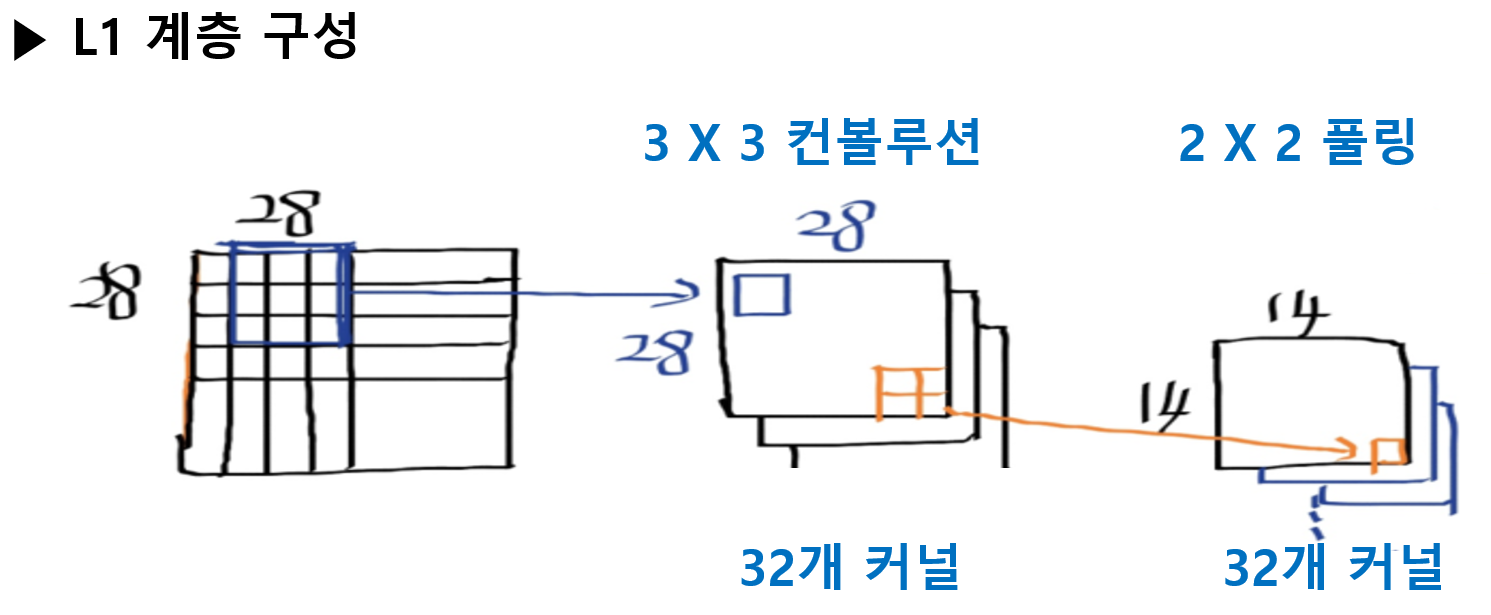

In [10]:
display(Image(filename="../img/L1_Cnn.png"))

### 원래 코드 
* W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
* L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')  
* L1 = tf.nn.relu(L1)  # 활성화 함수
* L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### 고수준 API를 이용하여 2줄로 줄임
* url : https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
* activation 기본은 None

In [12]:
L1 = tf.layers.conv2d(X,32,[3,3])
L1 = tf.layers.max_pooling2d(L1, [2,2], [2,2])
L1 = tf.layers.dropout(L1, 0.7, is_training)

Instructions for updating:
Use keras.layers.dropout instead.


### 두번째 계층 구성
* 두 번째 컨볼루션 계층의 커널인 W2의 변수의 구성은 [3,3,32,64]이다.
* 32는 앞서 구성된 첫 번째 컨볼루션 계층의 커널 개수이다.
* 즉 출력층의 개수이며, 첫 번째 컨볼루션 계층이 찾아낸 이미지의 특징 개수라고 할 수 있다.

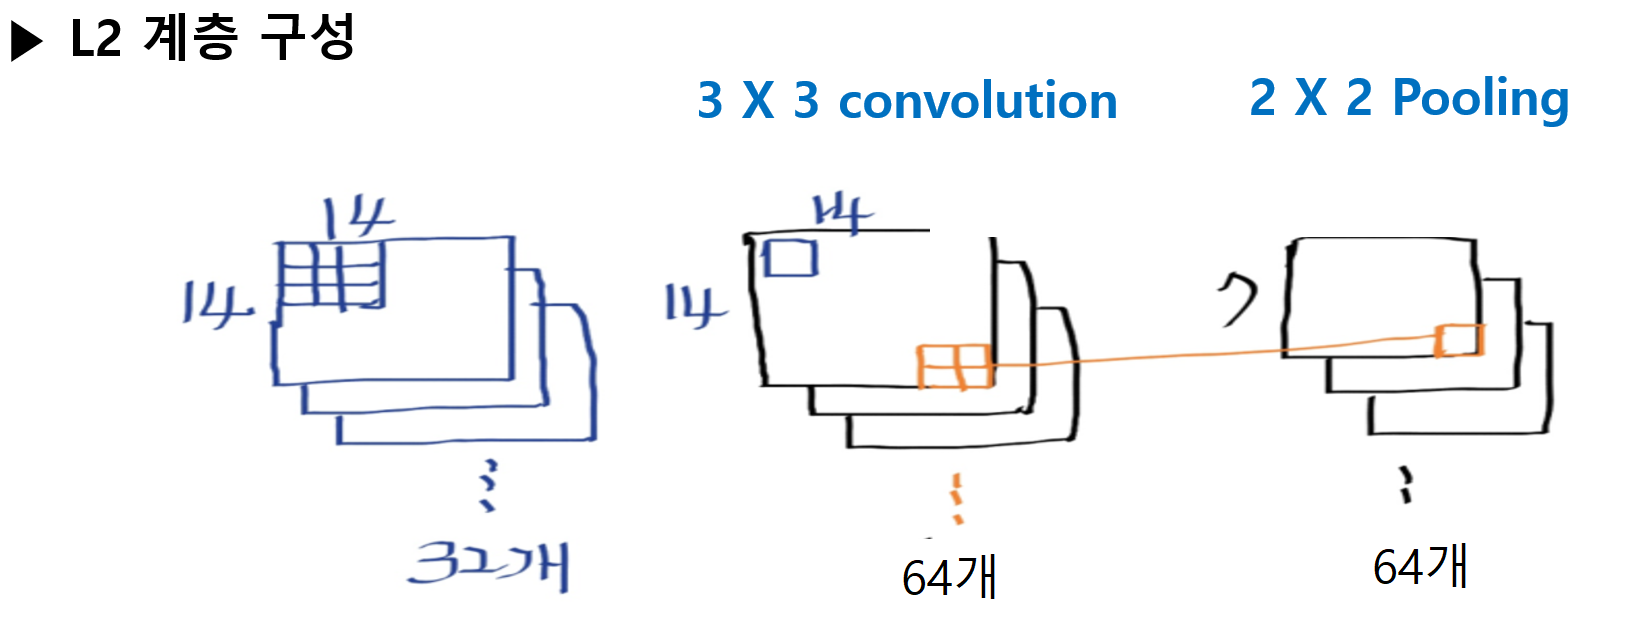

In [14]:
display(Image(filename="../img/L2_Cnn.png"))

In [15]:
# W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
# L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
# L2 = tf.nn.relu(L2)
# L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.layers.conv2d(L1, 64, [3,3])
L2 = tf.layers.max_pooling2d(L2, [2,2], [2,2])
L2 = tf.layers.dropout(L2, 0.7, is_training)

### 완전 연결 계층을 만드는 부분의 이전 코드

In [17]:
# W3 = tf.Variable(tf.random_normal([7 * 7 * 64, 256], stddev=0.01))
# L3 = tf.reshape(L2, [-1, 7 * 7 * 64])
# L3 = tf.matmul(L3, W3)
# L3 = tf.nn.relu(L3)
# L3 = tf.nn.dropout(L3, keep_prob)
L3 = tf.contrib.layers.flatten(L2)
L3 = tf.layers.dense(L3, 256, activation=tf.nn.relu)
L3 = tf.layers.dropout(L3, 0.5, is_training)

In [18]:
# 최종 출력값 L3 에서의 출력 256개를 입력값으로 받아서 0~9 레이블인 10개의 출력값을 만듭니다.
# W4 = tf.Variable(tf.random_normal([256, 10], stddev=0.01))
# model = tf.matmul(L3, W4)
model = tf.layers.dense(L3, 10, activation=None)

### 비용함수, 최적화 함수

In [19]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [20]:
%%time

#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)

for epoch in range(10):
    total_cost = 0

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # 이미지 데이터를 CNN 모델을 위한 자료형태인 [28 28 1] 의 형태로 재구성합니다.
        batch_xs = batch_xs.reshape(-1, 28, 28, 1)

        _, cost_val = sess.run([optimizer, cost],
                               feed_dict={X: batch_xs,
                                          Y: batch_ys,
                                          is_training: True})
        total_cost += cost_val

    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost =', '{:.3f}'.format(total_cost / total_batch))

print('최적화 완료!')

Epoch: 0001 Avg. cost = 0.174
Epoch: 0002 Avg. cost = 0.050
Epoch: 0003 Avg. cost = 0.033
Epoch: 0004 Avg. cost = 0.023
Epoch: 0005 Avg. cost = 0.016
Epoch: 0006 Avg. cost = 0.014
Epoch: 0007 Avg. cost = 0.011
Epoch: 0008 Avg. cost = 0.008
Epoch: 0009 Avg. cost = 0.008
Epoch: 0010 Avg. cost = 0.006
최적화 완료!
Wall time: 5min 14s


### 결과 확인

In [21]:
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy,
                        feed_dict={X: mnist.test.images.reshape(-1, 28, 28, 1),
                                   Y: mnist.test.labels,
                                   is_training: False}))

정확도: 0.987
